<a href="https://colab.research.google.com/github/sn0rkmaiden/neural-ode-practice/blob/main/Neural_ODE_and_RK4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Materials used:


*   [lecture on neural ODE](https://www.youtube.com/watch?v=sIFnARdTVvE)
*   [article with a hometask](https://deepschool-pro.notion.site/5c8f58b10a184a01af634260d2501aeb)
*   [about Runge-Kutta integrator](https://www.youtube.com/watch?v=HOWJp8NV5xU&t=1403s)
*   [deriving adjoint equation](https://vaipatel.com/deriving-the-adjoint-equation-for-neural-odes-using-lagrange-multipliers/)



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

1. Реализуйте интегратор RK4, он более точен для численного интегрирования дифференциальных уравнений по сравнению с методом Эйлера.

In [3]:
def RK4(f, y, t, dt):
  f_1 = f(t, y)
  f_2 = f(t + dt / 2, y + dt / 2 * f_1)
  f_3 = f(t + dt / 2, y + dt / 2 * f_2)
  f_4 = f(t + dt, y + dt * f_3)

  return y + dt / 6 * (f_1 + 2 * f_2 + 2 * f_3 + f_4)

2. Реализуйте правую часть ОДУ маятника, выбрав длину $L=1$, а $g=9.81$.
3. Случайным образом выберите начальные условия $y(t_0)$ для маятника и смоделируйте его поведение, начиная с выбранного начального условия. Используйте шаг времени $\Delta t = 0.01$ и проводите симуляцию в течение 1 секунды.

In [4]:
g = 9.81
L = 1

In [5]:
def pendulum(t, x):
  dz = [x[1], -g/L * np.sin(x[0])]
  return np.array(dz)

Initial values are - 17 79


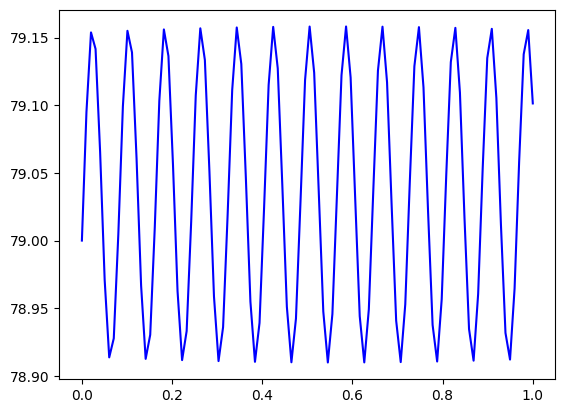

In [6]:
x0 = [np.random.randint(0, 100), np.random.randint(0, 100)]
print("Initial values are -", x0[0], x0[1])

dt = 0.01
T = 1
num_time_pts = int(T / dt)
t = np.linspace(0, T, num_time_pts)

X = np.zeros((2, num_time_pts))
X[:, 0] = x0
xin = x0

for i in range(num_time_pts - 1):
  x_t = RK4(pendulum, xin, t[i], dt)
  X[:, i + 1] = x_t
  xin = x_t

ax = plt.figure().add_subplot()
ax.plot(t, X[1, :], 'b')
plt.show()

4. Реализуйте adjoint method для НОДУ. Это позволит эффективно вычислять градиенты во время процесса обучения (этот пункт — пункт по желанию).

In [7]:
!pip install -q torchdiffeq

In [8]:
from torchdiffeq import odeint_adjoint as odeint

5. Создайте модель НОДУ и обучите ее предсказывать траекторию маятника. На вход модели подается начальное состояние, а на выходе получаются состояния на каждом шаге интегратора.

$h_t+1 = h_t + f(h_t, θ_t)$

In [5]:
class NeuralODE(nn.Module):
  def __init__(self, func):
    super().__init__()
    self.func = func

  def forward(self, y0, t, solver):
    solution = torch.empty(len(t), *y0.shape, dtype=y0.dtype, device=y0.device)
    solution[0] = y0

    j = 1
    for t0, t1 in zip(t[:-1], t[1:]):
      y1 = solver(self.func, y0, t0, t1-t0)
      solution[j] = y1
      j += 1
      y0 = y1

    return solution

In [13]:
class Pendulum(nn.Module):
  def forward(self, t, y):
    dy = [y[1], -g/L * torch.sin(y[0])]
    return torch.Tensor(dy).to(device)

In [7]:
# class cos(nn.Module):
  # def forward(self, t, y):
    # return torch.cos(t)

# y0 = torch.Tensor([[0]]).cuda()
# t = torch.linspace(0., 6*np.pi, 1500).cuda()

In [23]:
model = NeuralODE(func=Pendulum()).to(device)

In [44]:
y0 = torch.Tensor([np.random.randint(0, 100), np.random.randint(0, 100)]).to(device)
print("Initial values are -", y0[0], y0[1])
dt = 0.01
T = 1
num_time_pts = int(T / dt)
t = torch.linspace(0, T, num_time_pts).to(device)

Initial values are - tensor(8., device='cuda:0') tensor(28., device='cuda:0')


In [45]:
output = model(y0=y0, t=t, solver=RK4).transpose(0, 1)

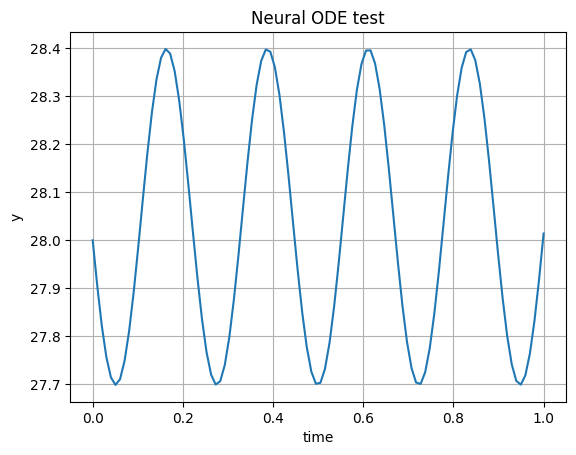

In [46]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Neural ODE test')
ax.set_xlabel('time')
ax.set_ylabel('y')
ax.plot(t.cpu().numpy(), output[1].detach().cpu().numpy())
plt.grid(True)
plt.show()

# Example with Lorenz 1963 ODE problem:

In [3]:
beta = 8 / 3
sigma = 10
rho = 28

In [4]:
def lorenz(t, x):
  dx = [sigma * (x[1] - x[0]),
        x[0] * (rho - x[2]) - x[1],
        x[0] * x[1] - beta * x[2]]
  return np.array(dx)

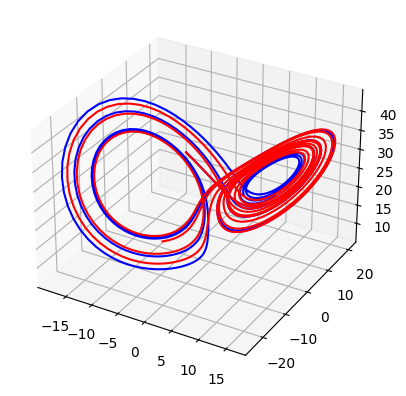

In [5]:
x0 = [-8, 8, 27]

dt = 0.01
T = 10
num_time_pts = int(T / dt)
t = np.linspace(0, T, num_time_pts)

X = np.zeros((3, num_time_pts))
X[:, 0] = x0
xin = x0

for i in range(num_time_pts - 1):
  x_t = RK4(lorenz, xin, t[i], dt)
  X[:, i + 1] = x_t
  xin = x_t

ax = plt.figure().add_subplot(projection='3d')
ax.plot(X[0, :], X[1, :], X[2, :], 'b')
solution = solve_ivp(lorenz, (0, T), x0, t_eval=t)
t = solution.t
x = solution.y.T
ax.plot(x[:, 0], x[:, 1], x[:, 2], 'r')
plt.show()